## Generate Data using SAMMY

This notebook works to couple the (recently) open source SAMMY code from ORNL to calculate a RRR cross section. The advantage of coupling to SAMMY is its ability to efficiently apply experimental corrections.

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
# import nuctools

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

In [2]:
%matplotlib widget

In [3]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


In [4]:
### calc calculate a full energy grid yourself 
# energy_grid = [75, 125]
energy_grid = [750, 825]

### or just give the min/max and the experiment object will do the above
# energy_grid = E_min_max

input_options = {'Add Noise': True,
            'Calculate Covariance': True,
            'Sample TURP': False,
            "Smooth Open Spectrum": True,
            "Sample TOCS": False}

experiment_parameters = {'bw': {'val':0.015,    'unc'   :   0},
                         'trigo': {'val':1e8,    'unc'   :   0},
                         'trigs': {'val':1e8,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)

289

In [5]:
spin_groups = [ (3.0,1,0) ]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

# average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':4.17, '4.0':4.99},
#                                     'Gg'    :   {'3.0':64.0, '4.0':64.0},
#                                     'gn2'    :   {'3.0':46.4, '4.0':35.5}  })
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':4.17, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':75.4, '4.0':35.5}  })                         
                                    
# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
resonance_ladder = pd.read_csv("./UPR_presentation_ladder.csv")


resonance_ladder

,Unnamed: 0,E,Gg,gn2,J,chs,lwave,J_ID,Gn,Gt
0,1,763.126121,61.206123,9.422718,3.0,1.0,0.0,1.0,0.924354,62.130478
1,2,768.937632,59.268165,116.427814,3.0,1.0,0.0,1.0,11.464799,70.732964
2,3,775.663193,61.152390,4.905508,3.0,1.0,0.0,1.0,0.485160,61.637550
3,4,780.052930,69.485494,0.040238,3.0,1.0,0.0,1.0,0.003991,69.489485
4,5,790.179438,60.645243,221.095295,3.0,1.0,0.0,1.0,22.070212,82.715455
5,6,794.026732,67.690695,25.309411,3.0,1.0,0.0,1.0,2.532583,70.223279
6,7,795.073479,65.220241,1.760043,3.0,1.0,0.0,1.0,0.176235,65.396475
7,8,797.901248,63.328705,24.320835,3.0,1.0,0.0,1.0,2.439592,65.768297
8,9,804.745634,66.001232,43.255103,3.0,1.0,0.0,1.0,4.357434,70.358666
9,10,813.765784,65.632117,118.928590,3.0,1.0,0.0,1.0,12.047588,77.679705


### Calculate cross section using SAMMY and run experiment

In [16]:
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'XCT',
    reaction = 'total',
    solve_bayes = False,
    inptemplate= "allexptot_1sg.inp",
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR_1',
    keep_runDIR = True,
    shell = 'zsh'
    )

# resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[16], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.DataFrame({'E':[24.0], 'Gg':[7.0], 'Gn':[4.0], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.read_csv("./UPR_presentation_ladder.csv")


sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,
    energy_grid = exp.energy_domain,
    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)

sammyOUT = sammy_functions.run_sammy(sammyINP, sammyRTO)
theo, par = sammyOUT.pw, sammyOUT.par

# sammyINP.resonance_ladder = resonance_ladder[resonance_ladder.Gn > 0.5]
sammyINP.resonance_ladder = resonance_ladder[resonance_ladder.Gn > 4]
sammyOUT_est = sammy_functions.run_sammy(sammyINP, sammyRTO)
est, est_par = sammyOUT_est.pw, sammyOUT_est.par


In [7]:
np.count_nonzero(resonance_ladder.Gn > 0.5)

8

In [8]:

exp.run(theo)
# exp.redpar - exp.theo_redpar

### Counts

In [9]:
# save_open =  exp.odat.c

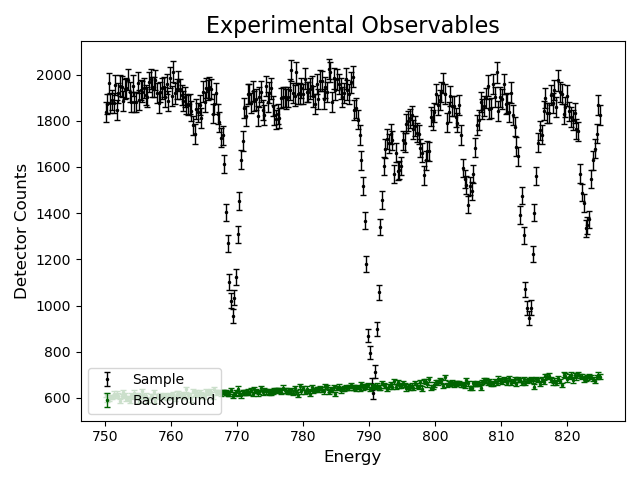

In [10]:
exp_alpha = 1
exp_labels = ["Sample", "Open", "Background"]
# exp_labels = [None, None, None]


figure()
errorbar(exp.sdat.E, exp.sdat.c, yerr=exp.sdat.dc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2,  alpha=exp_alpha, label=exp_labels[0]) #label='Sample',

# errorbar(exp.odat.E, exp.odat.c, yerr=exp.odat.dc, zorder=0, 
#                                         fmt='.', color='navy', linewidth=1, markersize=3, capsize=2, label='Open')
# errorbar(exp.odat.E, save_open, yerr=exp.odat.dc, zorder=0, 
#                                         fmt='.', color='navy', linewidth=1, markersize=3, capsize=2, alpha=exp_alpha, label=exp_labels[1])

errorbar(exp.sdat.E, np.random.normal(exp.sdat.E*1.2-300, scale=10, size=len(exp.sdat.E)), yerr=np.ones(len(exp.sdat.E))*10, 
                                        fmt='.', color='darkgreen', linewidth=1, markersize=3, capsize=2,  alpha=exp_alpha, label=exp_labels[2])


# plot(exp.odat.E, exp.odat.c, color='navy', label="True Open", lw=2)
# plot(exp.sdat.E, exp.theo_c, color='r', zorder=0, label="True Sample", lw=2)
# plot(exp.sdat.E, exp.sdat.E*1.2-300, 'darkgreen', label="True Background", lw=2)



# yscale('log')
# xscale('log')
title("Experimental Observables", fontsize=16)
xlabel('Energy', fontsize=12); ylabel('Detector Counts', fontsize=12)
legend(fontsize=10, loc="lower left")
tight_layout()

### Transmission

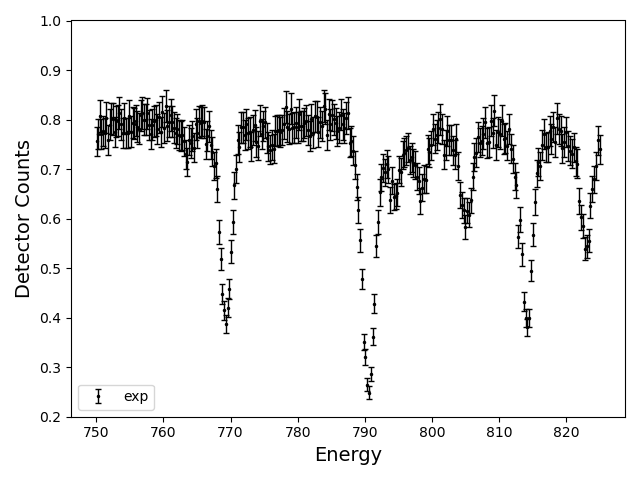

In [11]:
figure()
# plot(theo.E, theo.theo_trans, ms=1, color='r')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([.2, 1])
# xscale('log')
# title("Experimental Observables", fontsize=18)
xlabel('Energy', fontsize=14); ylabel('Detector Counts', fontsize=14)
legend(fontsize=10, loc="lower left")
tight_layout()

### Cross Section

In [12]:
from ATARI.utils.datacontainer import DataContainer
d = DataContainer()
d.add_theoretical(Ta_pair, resonance_ladder)
d.add_experimental(exp)
d.fill()


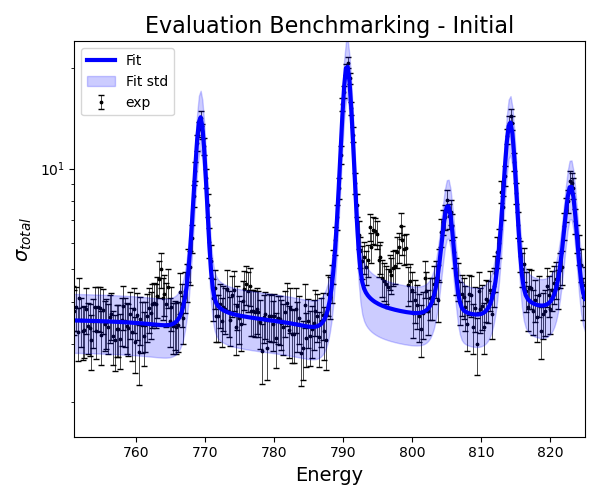

In [19]:


figure(figsize=(6,5))

errorbar(d.pw_exp.E, d.pw_exp.exp_xs, yerr=d.pw_exp.exp_xs_unc, zorder=0,
                                fmt='.', color='k', ecolor='k', linewidth=0.5, markersize=3.5, capsize=2, label='exp')

# plot(theo.E, theo.theo_xs, color='r', zorder=1, lw=3, label="True")
plot(est.E, est.theo_xs, color='b', zorder=2, lw=3, label="Fit")

# error = est.theo_xs**2/30
error = est.theo_xs/5
fill_between(est.E, est.theo_xs-error, est.theo_xs+error, color='b', alpha=0.2, label="Fit std")

ylim([1.58, 24])
xlim([751,825])
yscale('log')
# xscale('log')
ylabel(r'$\sigma_{total}$', fontsize=15)
xlabel('Energy (eV)', fontsize=15)

# title('Evaluation Benchmarking', fontsize=16)
title('Evaluation Benchmarking - Initial', fontsize=16)

xlabel('Energy', fontsize=14); ylabel(r'$\sigma_{total}$', fontsize=14)
legend(fontsize=10, loc="upper left")
tight_layout()

### resonance parameter distributions

Text(0.5, 1.0, 'Resonance Parameter Distributions')

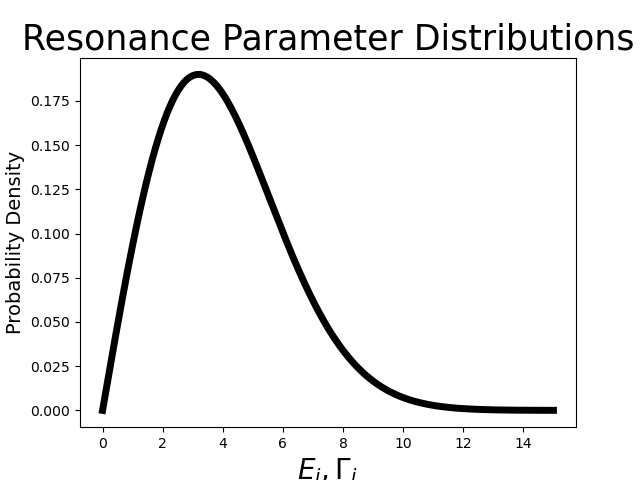

In [14]:
from ATARI.syndat.sample_levels import wigner_PDF

x = np.linspace(0,15, 1000)

figure()
plot(x, wigner_PDF(x, 4), 'k', lw=5)
ylabel("Probability Density", fontsize=14)
xlabel(r"$E_i, \Gamma_i$", fontsize=20)
title("Resonance Parameter Distributions", fontsize=25)



## Fitting

In [15]:
def get_parameter_grid(energy_grid, res_par_avg, num_Er, option=0):
    max_Elam = max(energy_grid) + res_par_avg['Gt99']/10e3
    min_Elam = min(energy_grid) - res_par_avg['Gt99']/10e3
    if option == 1:
        Gn = np.repeat(res_par_avg["Gn01"], num_Er)
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
    else:
        Gn = np.repeat(res_par_avg["<Gn>"], num_Er)
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
    Er = np.linspace(              min_Elam,              max_Elam,                num_Er)
    return Er, Gg, Gn

def get_resonance_ladder(Er, Gg, Gn1, varyE=1, varyGg=1, varyGn1=1):
    return pd.DataFrame({"E":Er, "Gg":Gg, "Gn1":Gn1, "varyE":np.ones(len(Er))*varyE, "varyGg":np.ones(len(Er))*varyGg, "varyGn1":np.ones(len(Er))*varyGn1 ,"J_ID":np.ones(len(Er))})

num_Er = 100
Er, Gg, Gn = get_parameter_grid(exp_pw.E, res_par_avg, num_Er, option=1)
initial_reslad = get_resonance_ladder(Er, Gg, Gn, varyE=0, varyGg=0, varyGn1=1)

NameError: name 'exp_pw' is not defined

In [ ]:
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    shell = 'zsh',
    model = 'XCT',
    reaction = 'transmission',
    solve_bayes = False,
    inptemplate = "allexptot_1sg.inp",
    inpname = "sammy.inp",
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR_TC_vGn1',
    keep_runDIR = True,
    )

sammyRTO_ls.keep_runDIR = True
iterations = 2
steps = 200
threshold = 0.01
reactions = ["transmission", "capture"]
templates = ["allexptot_1sg.inp", "allexpcap_1sg.inp"]

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = initial_reslad,

    datasets= datasets,
    dataset_titles= dataset_titles,
    reactions= reactions,
    templates= templates,
    
    steps = 100,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    initial_parameter_uncertainty = 0.01,

    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)


In [ ]:
par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

P2 = copy(par)
P2 = P2[P2.Gn1 > 1e-4]
P2["varyGg"] = np.ones(len(P2))
P2["varyE"] = np.ones(len(P2))

sammyRTO_ls.sammy_runDIR= "SAMMY_runDIR_TC_vGn1_E"
sammyINPyw.initial_parameter_uncertainty = 0.001
sammyINPyw.step_threshold = 0.001
sammyINPyw.resonance_ladder = P2

par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

In [ ]:
# import imageio

# for i in range(1,ifinal):
    
#     # C1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/cap1_step{i}.lst"))
#     T1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/trans1_step{i}.lst"))

#     # fig = plot_trans_cap(exp_pw, cap_pw, T1=T1, C1=C1)
#     fig = plot_trans(exp_pw, T1)
#     fig.savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/figures/case2a_{i}.png")
#     close()

In [ ]:

# images = []
# for i in range(1,ifinal): #range(start_job,end_job):
#     images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/figures/case2a_{i}.png"))
# imageio.mimsave(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/case_2a.gif", images)

